In [1]:
import numpy as np
from oceanmixedlayers import oceanmixedlayers
import matplotlib.pyplot as plt

import gsw as gsw
import xarray as xr
from glob import glob

%matplotlib inline

#When debugging...
%load_ext autoreload
%autoreload 2

def IsVarThere(hndl,VAR):
    CHECK = [A for A in hndl.data_vars  if A==VAR]
    return len(CHECK)>0

In [6]:
# Load in some Argo data for examples of using the omld package

Path_to_Argo = '/net3/bgr/Datasets/Argo/202011-ArgoData/' #User specific

#Some Floats w/ deep MLDs:
#ID = 'aoml/3900331'
#ID = 'aoml/3900451'
ID = 'aoml/3900660'

#Holte and Talley 2009 sample:
#ID='aoml/3900621/'

PATH = Path_to_Argo+'/dac/'+ID+'/'


PROFFILE = glob(PATH+'/*_prof.nc')

with xr.open_dataset(PROFFILE[0]) as hndl:

    if ( (IsVarThere(hndl,'TEMP'))&(IsVarThere(hndl,'PSAL'))):
        
        NP = hndl.N_PROF.size
        NZ = hndl.N_LEVELS.size
        
        # Initialize fields to compute from profiles
        # The profiles are going to be gridded to yield means
        # taken as representative of T/S over stacked layers,
        # effectively mimicing an ocean model vertical grid
        
        #> Central depth of layers
        Z_c_2d       = np.zeros([NP,NZ])+np.NaN
        #> Thickness of layers
        dZ_2d        = np.zeros([NP,NZ])+np.NaN
        # Central pressure of layers
        P_c_2d       = np.zeros([NP,NZ])+np.NaN
        # Thickness of layers in pressure space
        dP_2d        = np.zeros([NP,NZ])+np.NaN
        # Mean conservative temperature of layer
        CT_c_2d      = np.zeros([NP,NZ])+np.NaN
        # Mean practical salinity of layer
        PSal_c_2d    = np.zeros([NP,NZ])+np.NaN
        # Mean potential density (p=0) of layer
        Rho0_c_2d    = np.zeros([NP,NZ])+np.NaN
        # Gradient of potential density over layer
        dRho0dz_c_2d = np.zeros([NP,NZ])+np.NaN
        # A quality control flag for determining which floats to use
        GOOD         = np.zeros([NP],dtype=bool)
        
        # Step through the floats
        for p in range(NP):
            
            #Checking quality of date and position data
            DayQC = float(hndl.JULD_QC[p])
            PosQC = float(hndl.POSITION_QC[p])
            
            # 1 - Good data, 2 - Probably good data, 5 - value changed, 8 - value interpolated
            # We could be stricter on which profiles we use
            if (np.max(DayQC==np.array([1,2,5,8]))
                and 
                np.max(PosQC==np.array([1,2,5,8]))):
                
                #Checking quality of salinity, temperature, and pressure
                SALTQC = np.array(hndl.PSAL_QC[p,:],dtype=float)
                TEMPQC = np.array(hndl.TEMP_QC[p,:],dtype=float)
                PRESQC = np.array(hndl.PRES_QC[p,:],dtype=float)
                
                
                LI = (((SALTQC==1)|(SALTQC==2)|(SALTQC==5)|(SALTQC==8))
                      &
                      ((TEMPQC==1)|(TEMPQC==2)|(TEMPQC==5)|(TEMPQC==8))
                      &
                      ((PRESQC==1)|(PRESQC==2)|(PRESQC==5)|(PRESQC==8)))
                
                #Make sure we have at least 20 good data points in the profile
                if (np.sum(LI)>20):
                    Pressure = np.array(hndl.PRES[p,:][LI],dtype=float)
                    PSal = np.array(hndl.PSAL[p,:].values[LI],dtype=float)
                    Temp = np.array(hndl.TEMP[p,:].values[LI],dtype=float)
                    GOOD[p]=True # We will use this profile
                else:
                    GOOD[p]=False # We will skip this profile

                if GOOD[p]:
                    
                    #Computes in-situ density from S, in-situ T, and P
                    Rho = gsw.density.rho_t_exact(PSal,Temp,Pressure)
                    #Computes conservative temperature from Rho, S, and P
                    CT = gsw.conversions.CT_from_rho(Rho,PSal,Pressure)[0]
                    #Computes potential density from S and conservative T
                    Rho0 = gsw.density.rho(PSal,CT,0)
                    
                    #Set a zero surface pressure bin (extrapolate results from shallowest
                    # observation to surface)
                    P_i = np.array([0.]+list(Pressure))
                    
                    #First guess at Z_i from pressure (which is in dBars)
                    Z_i = -1.*P_i
                    dZ = (Z_i[:-1]-Z_i[1:])
                    
                    if (np.min(dZ)<=0 or np.max(dZ)>100):
                        #Final QC that we have reasonable thicknesses of layers (distance between obs)
                        GOOD[p]=False # skip the profile if not
                    else:
                        
                        #Construct the "interface" values from the measurements and
                        # repeating the shallowest measurement at the surface
                        CT_i = np.array([CT[0]]+list(CT))
                        PSal_i = np.array([PSal[0]]+list(PSal))
                        Rho0_i = np.array([Rho0[0]]+list(Rho0))

                        #Compute central pressure of layers and thickness in pressure
                        P_c       = 0.5*(P_i[1:]+P_i[:-1])
                        dP        = (P_i[:-1]-P_i[1:])
                        # Compute mean conservative temperature, salinity, and potential density
                        # NOTE: the potential density could have been computed from the 
                        #       mean CT_c and PSal_c; meaning potential density directly was a 
                        #       choice that makes it easier to compute a consistent potential density
                        #       gradient over the layer.  The CT_c and PSal_c are not used with
                        #       Rho0_c, which makes this potential inconsistency not a concern.
                        CT_c      = 0.5*(CT_i[1:]+CT_i[:-1])
                        PSal_c    = 0.5*(PSal_i[1:]+PSal_i[:-1])
                        Rho0_c    = 0.5*(Rho0_i[1:]+Rho0_i[:-1])
                        dRho0dz_c = (Rho0_i[...,:-1]-Rho0_i[...,1:])/dZ

                        #However, we do want to get the density of the layer from the mean CT and
                        # PSal, as it will give a more accurate estimate of the mean density of the
                        # layer.  This could be done more accurately by allowing pressure and possibly
                        # temperature and salinity to vary linearly in the layer.  But for now
                        # this seems like a decent enough way to estimate density, which is done
                        # to estimate thickness in space from thickness in pressure.
                        
                        Rho = gsw.density.rho(PSal,CT_c,P_c)
                        #Compute Z_i referenced to a z=0 surface using layer mean density
                        # and assuming hydrostatic pressure
                        for zi in range(len(Rho)):
                            Z_i[zi+1]=Z_i[zi]+1.e4*dP[zi]/(9.81*Rho[zi])
                        Z_c = 0.5*(Z_i[1:]+Z_i[:-1])
                        dZ = (Z_i[:-1]-Z_i[1:])
                        
                        LG = len(Z_c)
                        
                        #Fill the 2d fields to store for computing.
                        # The mixedlayerdepth codes are all vectorized to greatly speed up the calculation
                        # if all done at once instead of column by column.
                        
                        CT_c_2d[p,:LG] = CT_c
                        PSal_c_2d[p,:LG] = PSal_c
                        P_c_2d[p,:LG] = P_c
                        Z_c_2d[p,:LG] = Z_c
                        dRho0dz_c_2d[p,:LG] = dRho0dz_c
                        Rho0_c_2d[p,:LG] = Rho0_c
                        dZ_2d[p,:LG] = dZ
                        dP_2d[p,:LG] = dP
        print(ID,'yielded',np.sum(GOOD),'good profiles out of',NP)

aoml/3900660 yielded 204 good profiles out of 304


Text(0.5, 0, 'Sal (g/kg)')

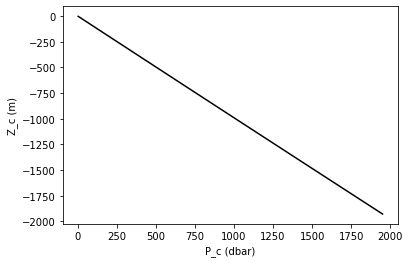

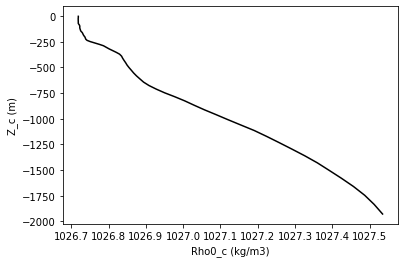

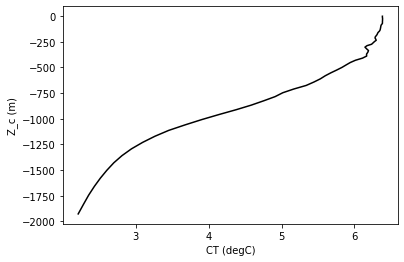

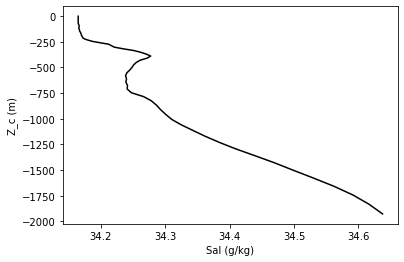

In [7]:
#Visualize some of the data

plt.figure()
plt.plot(P_c_2d[GOOD,:][0,:],
         Z_c_2d[GOOD,:][0,:],
         'k-'
        )
plt.ylabel('Z_c (m)')
plt.xlabel('P_c (dbar)')

plt.figure()
plt.plot(Rho0_c_2d[GOOD,:][0,:],
         Z_c_2d[GOOD,:][0,:],
         'k-'
        )
plt.ylabel('Z_c (m)')
plt.xlabel('Rho0_c (kg/m3)')

plt.figure()
plt.plot(CT_c_2d[GOOD,:][0,:],
         Z_c_2d[GOOD,:][0,:],
         'k-'
        )
plt.ylabel('Z_c (m)')
plt.xlabel('CT (degC)')

plt.figure()
plt.plot(PSal_c_2d[GOOD,:][0,:],
         Z_c_2d[GOOD,:][0,:],
         'k-'
        )
plt.ylabel('Z_c (m)')
plt.xlabel('Sal (g/kg)')

In [16]:
Timing = True

if Timing:
    import time

# Part 1.
# The following code diagnoses the MLD using various methods from the Argo observations.

    
# Compute a series of MLDs using the threshold method:
# We could do these from the interfaces, but we are trying to make it compatible with how
# a model computes it.
if Timing: _=time.time()
MLD_003,MLD_003i = oceanmixedlayers.threshold(-Z_c_2d[GOOD,:].T,
                                              Rho0_c_2d[GOOD,:].T,
                                              delta=0.03,
                                              ref=10
                                             )  

# Compute a series of MLDs using the gradient method:
if Timing: a=time.time()
MLD_gradient,MLD_gradienti = oceanmixedlayers.gradient(-Z_c_2d[GOOD,:].T,
                                                       -Rho0_c_2d[GOOD,:].T, #We use negative because algorithm is written for temperature gradients
                                                       critical_gradient=0.0005
                                                      )  

# Compute a series of MLDs using the linearfit method
if Timing: b=time.time()
MLD_linfit,MLD_linfiti = oceanmixedlayers.linearfit(-Z_c_2d[GOOD,:].T,
                                                    -Rho0_c_2d[GOOD,:].T,#We use negative because algorithm is written for temperature gradients
                                                    error_tolerance=1.e-10)  

# Compute a series of MLDs using the Holte and Talley algorithm method
#Note that this returns an MLD in units of dBars, which should be converted to m via density1
if Timing: c=time.time()
OUT = oceanmixedlayers.holtetalley(P_c_2d[GOOD,:].T,
                                 PSal_c_2d[GOOD,:].T,
                                 CT_c_2d[GOOD,:].T,
                                 Rho0_c_2d[GOOD,:].T)
MLD_ht=OUT[2]

# Compute a series of MLDs using the PE anomaly accounting for a gradient in Rho0 over a layer
if Timing: d=time.time()
MLD_pelin = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                            dZ_2d[GOOD,:].T,
                                            Rho0_c_2d[GOOD,:].T,
                                            dRho0dz_c_2d[GOOD,:].T,
                                            energy=10.,
                                            gradient=True
                                           )

# Compute a series of MLDs using the PE anomaly assuming constant Rho0 over a layer
if Timing: e=time.time()
MLD_pe = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                         dZ_2d[GOOD,:].T,
                                         Rho0_c_2d[GOOD,:].T,
                                         energy=10.,
                                         gradient=False
                                        )

# Compute a series of MLDs using the temperature and salinity to compute the PE
# implications of stratification to a certain depth.
if Timing: f=time.time()
MLD_delta = oceanmixedlayers.mld_delta_pe(P_c_2d[GOOD,:].T,
                                          dP_2d[GOOD,:].T,
                                          CT_c_2d[GOOD,:].T,
                                          PSal_c_2d[GOOD,:].T,
                                          energy=10.,
                                         )

# Part 2.
# The following code diagnoses the PE anomaly of the MLD yielded from the methods above

if Timing: g=time.time()
    
# Compute the PE anomaly for the threshold MLD
e_MLD_003 = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                        dZ_2d[GOOD,:].T,
                                        Rho0_c_2d[GOOD,:].T,
                                        dRho0dz_c_2d[GOOD,:].T,
                                        depth=-MLD_003,
                                        gradient=True
                                       )
# Compute the PE anomaly for the gradient MLD
e_MLD_gradient = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                             dZ_2d[GOOD,:].T,
                                             Rho0_c_2d[GOOD,:].T,
                                             dRho0dz_c_2d[GOOD,:].T,
                                             depth=-MLD_gradient,
                                             gradient=True
                                            )
# Compute the PE anomaly for the linearfit MLD
e_MLD_linfit = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                           dZ_2d[GOOD,:].T,
                                           Rho0_c_2d[GOOD,:].T,
                                           dRho0dz_c_2d[GOOD,:].T,
                                           depth=-MLD_linfit,
                                           gradient=True
                                          )
# Compute the PE anomaly for the Holte and Talley MLD
e_MLD_ht = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                       dZ_2d[GOOD,:].T,
                                       Rho0_c_2d[GOOD,:].T,
                                       dRho0dz_c_2d[GOOD,:].T,
                                       depth=-MLD_ht,
                                       gradient=True
                                      )
# Compute the PE anomaly for the PE anomaly MLD (w/ gradient)
e_MLD_pelin = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                          dZ_2d[GOOD,:].T,
                                          Rho0_c_2d[GOOD,:].T,
                                          dRho0dz_c_2d[GOOD,:].T,
                                          depth=-MLD_pelin,
                                          gradient=True
                                         )
# Compute the PE anomaly for the PE anomaly MLD
e_MLD_pe = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                       dZ_2d[GOOD,:].T,
                                       Rho0_c_2d[GOOD,:].T,
                                       dRho0dz_c_2d[GOOD,:].T,
                                       depth=-MLD_pe,
                                       gradient=True
                                      )
# Compute the PE anomaly for the PE anomaly MLD
e_MLD_delta = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                          dZ_2d[GOOD,:].T,
                                          Rho0_c_2d[GOOD,:].T,
                                          dRho0dz_c_2d[GOOD,:].T,
                                          depth=-MLD_delta,
                                          gradient=True
                                         )



<ipython-input-15-d4c09826d587>:25: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,)


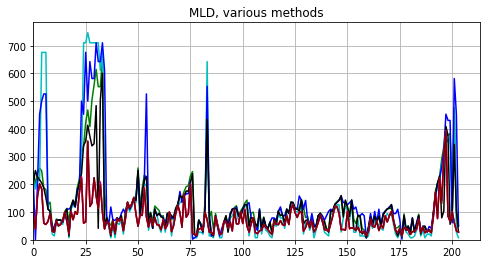

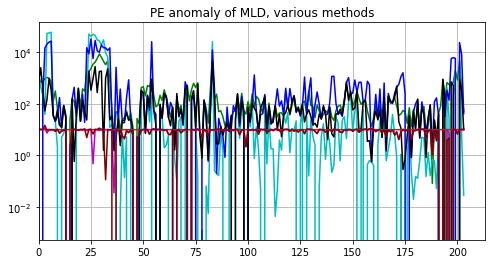

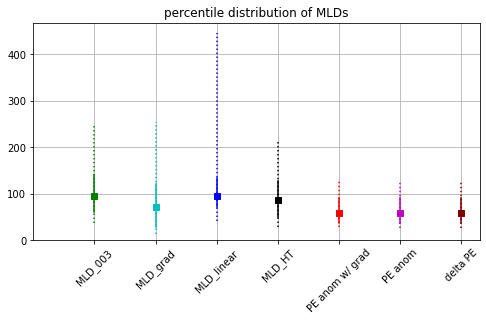

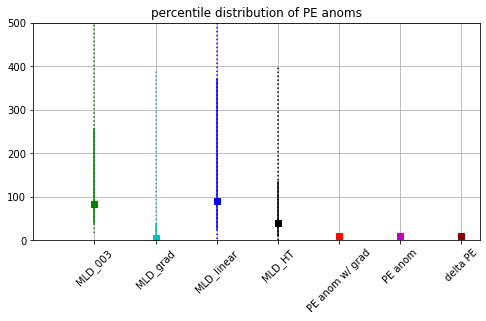

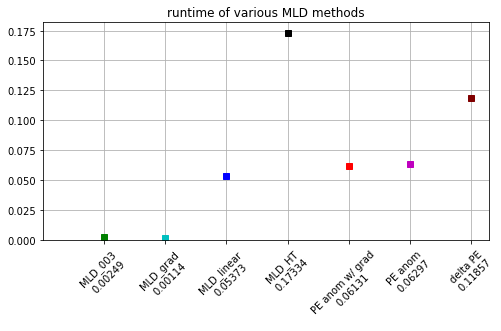

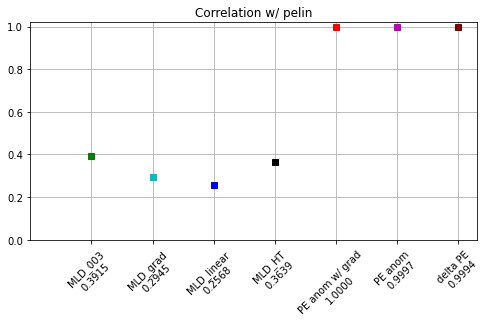

In [15]:
# Some rough plots, these need to be cleaned up

plt.figure(figsize=(8,4))
plt.plot(MLD_003,'g-')
plt.plot(MLD_gradient,'c-')
plt.plot(MLD_linfit,'b-')
plt.plot(MLD_ht,'k-')
plt.plot(MLD_pelin,'r-')
plt.plot(MLD_pe,'m-')
plt.plot(MLD_delta,'-',color='maroon')
plt.xlim(0,)
plt.ylim(0,)
plt.grid(True)
plt.title('MLD, various methods')

plt.figure(figsize=(8,4))
plt.semilogy(e_MLD_003,'g-')
plt.plot(e_MLD_gradient,'c-')
plt.plot(e_MLD_linfit,'b-')
plt.plot(e_MLD_ht,'k-')
plt.plot(e_MLD_pelin,'r-')
plt.plot(e_MLD_pe,'m-')
plt.plot(e_MLD_delta,'-',color='maroon')
plt.xlim(0,)
plt.ylim(0,)
plt.grid(True)
plt.title('PE anomaly of MLD, various methods')

plt.figure(figsize=(8,4))
def boxwhisk(index,MLD,color='k'):
    plt.plot(index,np.median(MLD),'s',color=color)
    plt.plot([index,index],[np.percentile(MLD,10),np.percentile(MLD,90)],':',color=color)
    plt.plot([index,index],[np.percentile(MLD,25),np.percentile(MLD,75)],'-',color=color)
boxwhisk(1,MLD_003,color='g')
boxwhisk(2,MLD_gradient,color='c')
boxwhisk(3,MLD_linfit,color='b')
boxwhisk(4,MLD_ht,color='k')
boxwhisk(5,MLD_pelin,color='r')
boxwhisk(6,MLD_pe,color='m')
boxwhisk(7,MLD_delta,color='maroon')
plt.xlim(0,)
plt.ylim(0,)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7],['MLD_003','MLD_grad','MLD_linear','MLD_HT','PE anom w/ grad','PE anom', 'delta PE'],rotation=45)
plt.title('percentile distribution of MLDs')

plt.figure(figsize=(8,4))
def boxwhisk(index,MLD,color='k'):
    plt.plot(index,np.nanmedian(MLD),'s',color=color)
    plt.plot([index,index],[np.nanpercentile(MLD,10),np.nanpercentile(MLD,90)],':',color=color)
    plt.plot([index,index],[np.nanpercentile(MLD,25),np.nanpercentile(MLD,75)],'-',color=color)
boxwhisk(1,e_MLD_003,color='g')
boxwhisk(2,e_MLD_gradient,color='c')
boxwhisk(3,e_MLD_linfit,color='b')
boxwhisk(4,e_MLD_ht,color='k')
boxwhisk(5,e_MLD_pelin,color='r')
boxwhisk(6,e_MLD_pe,color='m')
boxwhisk(7,e_MLD_delta,color='maroon')
plt.xlim(0,)
plt.ylim(0,)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7],['MLD_003','MLD_grad','MLD_linear','MLD_HT','PE anom w/ grad','PE anom', 'delta PE'],rotation=45)
plt.title('percentile distribution of PE anoms')
plt.ylim(0,500)

if Timing: 
    plt.figure(figsize=(8,4))
    plt.plot(1,(a-_),'gs')
    plt.plot(2,(b-a),'cs')
    plt.plot(3,(c-b),'bs')
    plt.plot(4,(d-c),'ks')
    plt.plot(5,(e-d),'rs')
    plt.plot(6,(f-e),'ms')
    plt.plot(7,(g-f),'s',color='maroon')
    plt.xlim(0,)
    plt.ylim(0,)
    plt.grid(True)
plt.xticks([1,2,3,4,5,6,7],['MLD_003 \n{:6.5f}'.format((a-_)),
                            'MLD_grad \n{:6.5f}'.format((b-a)),
                            'MLD_linear \n{:6.5f}'.format((c-b)),
                            'MLD_HT \n{:6.5f}'.format((d-c)),
                            'PE anom w/ grad \n{:6.5f}'.format((e-d)),
                            'PE anom \n{:6.5f}'.format((f-e)),
                            'delta PE \n{:6.5f}'.format((g-f))],
                            rotation=45)
plt.title('runtime of various MLD methods')

plt.figure(figsize=(8,4))
plt.plot(1,np.corrcoef(MLD_pelin,MLD_003)[1,0]**2,'gs')
plt.plot(2,np.corrcoef(MLD_pelin,MLD_gradient)[1,0]**2,'cs')
plt.plot(3,np.corrcoef(MLD_pelin,MLD_linfit)[1,0]**2,'bs')
plt.plot(4,np.corrcoef(MLD_pelin,MLD_ht)[1,0]**2,'ks')
plt.plot(5,np.corrcoef(MLD_pelin,MLD_pelin)[1,0]**2,'rs')
plt.plot(6,np.corrcoef(MLD_pelin,MLD_pe)[1,0]**2,'ms')
plt.plot(7,np.corrcoef(MLD_pelin,MLD_delta)[1,0]**2,'s',color='maroon')
plt.ylim(0.,1.02)
plt.xlim(0,)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7],['MLD_003 \n{:4.4f}'.format(np.corrcoef(MLD_pelin,MLD_003)[1,0]**2),
                            'MLD_grad \n{:4.4f}'.format(np.corrcoef(MLD_pelin,MLD_gradient)[1,0]**2),
                            'MLD_linear \n{:4.4f}'.format(np.corrcoef(MLD_pelin,MLD_linfit)[1,0]**2),
                            'MLD_HT \n{:4.4f}'.format(np.corrcoef(MLD_pelin,MLD_ht)[1,0]**2),
                            'PE anom w/ grad \n{:4.4f}'.format(np.corrcoef(MLD_pelin,MLD_pelin)[1,0]**2),
                            'PE anom \n{:4.4f}'.format(np.corrcoef(MLD_pelin,MLD_pe)[1,0]**2),
                            'delta PE \n{:4.4f}'.format(np.corrcoef(MLD_pelin,MLD_delta)[1,0]**2)],
                            rotation=45)
plt.title('Correlation w/ pelin')

pass;

Text(0, 0.5, 'delta PE')

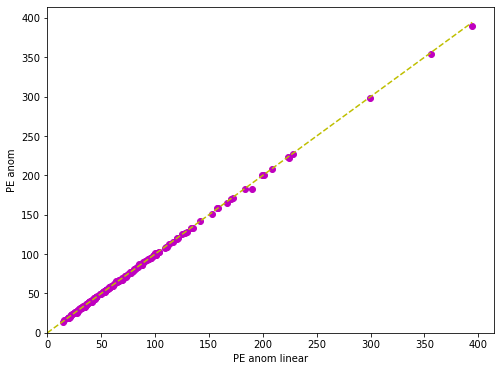

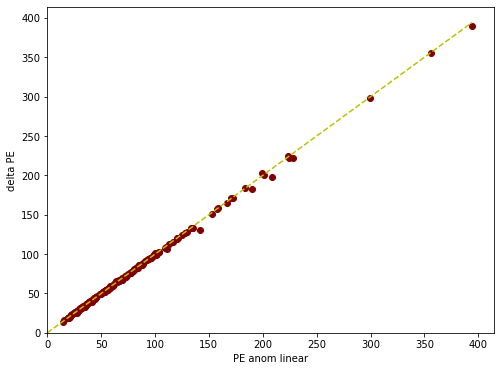

In [13]:
plt.figure(figsize=(8,6))
plt.plot(MLD_pelin,MLD_pe,'mo')
plt.plot([0,max(MLD_pelin)],[0,max(MLD_pelin)],
        'y--')
plt.xlim(0,max(MLD_pelin)+20)
plt.ylim(0,max(MLD_pelin)+20)
plt.xlabel('PE anom linear')
plt.ylabel('PE anom')

plt.figure(figsize=(8,6))
plt.plot(MLD_pelin,MLD_delta,'o',color='maroon')
plt.plot([0,max(MLD_pelin)],[0,max(MLD_pelin)],
        'y--')
plt.xlim(0,max(MLD_pelin)+20)
plt.ylim(0,max(MLD_pelin)+20)
plt.xlabel('PE anom linear')
plt.ylabel('delta PE')


(-3.0, 3.0)

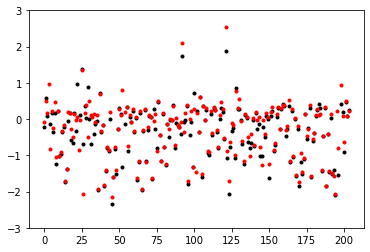

In [14]:
plt.plot(MLD_delta-MLD_pelin,'k.')
plt.plot(MLD_pe-MLD_pelin,'r.')
plt.ylim(-3,3)